## Initialize Setup

In [1]:
!git clone --branch ini_setup https://dagshub.com/arjiomega/cat-vs-dog-multiclass-semantic-segmentation.git

Cloning into 'cat-vs-dog-multiclass-semantic-segmentation'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 225 (delta 109), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (225/225), 4.53 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [2]:
%cd cat-vs-dog-multiclass-semantic-segmentation

/content/cat-vs-dog-multiclass-semantic-segmentation


In [3]:
!pip install -r requirements.txt --quiet --progress-bar off

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.12.2 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.3 which is incompatible.


In [4]:
%env MLFLOW_TRACKING_URI mlflow_uri
%env MLFLOW_TRACKING_USERNAME username
%env MLFLOW_TRACKING_PASSWORD password
%env PYTHONPATH pythonpath

env: MLFLOW_TRACKING_URI=https://dagshub.com/arjiomega/cat-vs-dog-multiclass-semantic-segmentation.mlflow
env: MLFLOW_TRACKING_USERNAME=arjiomega
env: MLFLOW_TRACKING_PASSWORD=176ff8adae58be35efa6292f4a010918a4c1a459
env: PYTHONPATH=/content/cat-vs-dog-multiclass-semantic-segmentation


In [5]:
#!dvc remote add origin s3://dvc
!dvc remote modify origin endpointurl dagshub_endpoint
!dvc remote modify origin --local access_key_id access_key_id
!dvc remote modify origin --local secret_access_key secret_access_key

In [6]:
!dvc pull -r origin

Streaming output truncated to the last 5000 lines.
!

  0%|          |dvc/files/md5/15/6799697b590efdad870.00/? [00:00<?,        ?B/s]

  0% 0.00/110k [00:00<?, ?B/s{'info': ''}]                                      


!


  0%|          |dvc/files/md5/e3/dc7fae814cb8d462d80.00/? [00:00<?,        ?B/s]


  0% 0.00/73.7k [00:00<?, ?B/s{'info': ''}]                                     


                                           

                                          

!

  0%|          |dvc/files/md5/fc/2f4c606f37a96b70f10.00/? [00:00<?,        ?B/s]

  0% 0.00/91.1k [00:00<?, ?B/s{'info': ''}]                                     
Fetching from s3:  97% 17881/18444 [04:52<00:09, 57.35file/s{'info': ''}]

                                           

!

  0%|          |dvc/files/md5/9e/a528567a4e597794d50.00/? [00:00<?,        ?B/s]

  0% 0.00/90.6k [00:00<?, ?B/s{'info': ''}]                                     

                                           

!

  0%|          |dvc/f

Generate processed data

In [7]:
!python src/data/make_dataset.py

## Finetuning model

In [8]:
import os
import urllib
import datetime
import argparse
from pathlib import Path

import cv2
import mlflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from config import config
import src.models.model_setup
from src.data.load import load
from src.models.model_components.callbacks import plot_predict
from src.experiment_tracking.track_experiment import TrackExperiment
from src.data.data_utils import load_label_dict, load_list, load_args

58889256/58889256 [==============================] - 0s 0us/step


### load model from mlflow experiment artifact

In [52]:
model_uri = 'sample_uri'
model = mlflow.tensorflow.load_model(model_uri)

2023/12/13 10:02:33 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


In [48]:
model.layers[1].trainable

True

In [49]:
for layer in model.layers[1].layers:
    print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f0a104bc6a0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a104be6b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a104bdd20> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a187c2740> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a10495060> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187e4bb0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a103280a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a1032a380> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a10328730> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a10329810> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a10328220> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a103289d0> False
<keras.src.layers.convolutional.conv2d.Conv2D obj

In [59]:
print(type(model.layers[1].layers))

<class 'list'>


In [71]:
LAYERS_TO_FINETUNE = 2
for layer in model.layers[1].layers[::-1][:LAYERS_TO_FINETUNE]:
    layer.trainable = True

In [72]:
for layer in model.layers[1].layers:
    print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f0a9bdf6d70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bdf4820> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bdf7e80> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a9bdf70a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bced240> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bcefb20> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a9bced8a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bced9c0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bced150> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bceec50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a9bceef80> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a9bced120> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [23]:
def preprocess(img):
    #resize
    preprocess_img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
    #normalize
    preprocess_img = (preprocess_img/127.5) - 1.0

    return preprocess_img

def img_loader(url):
    response = urllib.request.urlopen(url)

    img = np.asarray(bytearray(response.read()), dtype="uint8")
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def predict(model,img):
    # preprocess for model prediction
    preprocess_img = preprocess(img)
    preprocess_img = np.expand_dims(preprocess_img, axis=0)

    # generate mask from model
    predict_mask = model.predict(preprocess_img)

    threshold = 0.5
    predict_mask = np.where(predict_mask > threshold, 1, 0)

    img_plot = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)

    fig, arr = plt.subplots(1,4)

    arr[0].set_title('test')
    arr[0].imshow(img_plot)
    arr[0].axis('off')
    arr[1].set_title('background')
    arr[1].imshow(predict_mask[...,0].squeeze())
    arr[1].axis('off')
    arr[2].set_title('cat')
    arr[2].imshow(predict_mask[...,1].squeeze())
    arr[2].axis('off')
    arr[3].set_title('dog')
    arr[3].imshow(predict_mask[...,2].squeeze())
    arr[3].axis('off')

    #print(np.unique(test))

    return preprocess_img, predict_mask

Visualize model performance

1/1 [==============================] - 0s 332ms/step


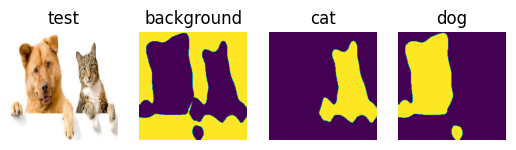

In [24]:
URL_ = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"
img = img_loader(URL_)
processed_img, predict_mask = predict(model,img)

### Visualize pretrained model used for transfer learning

VGG16 Architecture

![vgg architecture](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

![vgg architecture map](https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16-1024x450.jpg)

[img src](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

- VGG16 trained using imagenet dataset was used for the upsampling of the U-net model.
- For the finetuning, the last layers are going to be unfreezed to further learn from the data.

In [25]:
for layer in model.layers:
    print(layer)

This layer `<keras.src.engine.functional.Functional object at 0x7d32a0c66770>` is the pretrained vgg16 model where we are going to unfreeze some of the layers from the last part.

In [26]:
# vgg16
for layer in model.layers[1].layers:
    print(layer)

Unfreeze some of the layers

In [45]:
LAYERS_TO_FINETUNE = 2
for layer in model.layers[1].layers[:-LAYERS_TO_FINETUNE]:
    layer.trainable = True

In [46]:
for layer in model.layers[1].layers:
    print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f0a187cb5e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187cbd30> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c8250> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a187c0280> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c0640> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c0dc0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a187c1540> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c18d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c2050> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c27d0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0a187c2f50> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f0a187c32e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f

### Train model

In [73]:
def load_data(args):

    data_list = load_list.load(config.PROCESSED_IMG_DIR,config.PROCESSED_MASK_DIR)
    mask_label = load_label_dict.load(Path(config.RAW_DATA_DIR,'annotations'),'list.txt') #transfer path of list.txt

    train_set, valid_set, test_set = load.load_batches(data_list,
                                                       mask_label,
                                                       config.PROCESSED_IMG_DIR,
                                                       config.PROCESSED_MASK_DIR,
                                                       args)

    return train_set, valid_set, test_set

In [74]:
args = {
        "setup": {
            "model": "VGG16-Unet",
            "loss": "DiceLoss",
            "metrics": ["IoU","sensitivity","specificity"],
            "n_classes": 3,
            "random_seed": 5,
            "train_split": 0.9,
            "valid_split": 0.08,
            "test_split": 0.02
        },
        "params": {
            "learning_rate": 1e-5,
            "batch_size": 64,
            "epochs": 1
        },
        "tags": {
            "base_model": "UNet",
            "encoder": "VGG16",
            "loss": "DiceLoss gamma 1",
            "data split": "imbalance",
            "trained on": "paperspace P5000 16gb"
        },
        "experiment": {
            "experiment_name": "Pet Semantic Segmentation",
            "run_name": "Paperspace run 4: continue run 3"
        }
    }

In [75]:
train_set, valid_set, test_set = load_data(args)

In [76]:
model.fit(train_set)

103/103 [==============================] - 237s 2s/step - loss: 0.0663 - IoU: 0.9059 - sensitivity: 0.9552 - specificity: 0.9776


In [36]:
model.layers[1].trainable

True